### Evaluation CPSS

In [ ]:
### Load libraries
import itertools
import features
import numpy as np
import utils
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import dataloader
import pitchspace

def computeChromaData(dset,track_id,time_interval,source_separation="none"):
    dataset = dataloader.Dataloader(dset,"/home/max/ET-TI/Masterarbeit/chord-recognition/mirdata",source_separation)
    audiopath, annotationpath = dataset[track_id] 
    sig = utils.loadAudiofile(audiopath, offset=time_interval[0], duration=time_interval[1]-time_interval[0])
    gt = utils.loadChordAnnotations(annotationpath)
    chroma,pitchgram,pitchgram_cqt = features.crpChroma(sig)
    t_chroma = utils.timeVector(chroma.shape[1],t_start=time_interval[0],t_stop=time_interval[1],hop_length=2048)
    return sig,gt,t_chroma,chroma,pitchgram,pitchgram_cqt

def plotData(sig,gt,t_chroma,chroma,pitchgram,hcdf,stable_regions,time_interval):
    rms = features.computeRMS(sig)
    t_audio = utils.timeVector(sig.shape[0],t_start=time_interval[0],t_stop=time_interval[1],hop_length=1)
    fig,(ax0,ax1,ax2,ax3,ax4) = plt.subplots(5,1,height_ratios=(1,5,10,5,5),figsize=(8,6))
    utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval)
    ax0.set_title('Annotations',fontsize=10)
    ax1.plot(t_audio,sig)
    ax1.set_ylabel("Amplitude")
    ax1.grid("on")
    ax12 = ax1.twinx()
    ax12.plot(t_chroma,rms,'-',color="r")
    ax12.set_ylabel("RMS in dB", color='red')
    ax12.tick_params('y', colors='red')
    # plot cqt
    utils.plotCQT(ax2,t_chroma,pitchgram,time_interval)
    ax2.set_ylim(100,1000)
    # plot chroma
    utils.plotChromagram(ax3,t_chroma,chroma,time_interval)

    ax4.plot(t_chroma,hcdf)
    for x,y in itertools.pairwise(stable_regions):
        x_i0,x_i1 = x 
        y_i0,y_i1 = y
        rect = patches.Rectangle((t_chroma[x_i1],-0.5),t_chroma[y_i0] - t_chroma[x_i1],12,facecolor="k",alpha=0.1,edgecolor="k")
        ax3.add_patch(rect)
        ax3.add_artist(rect)

    for indices in stable_regions:
        ax4.hlines(1,t_chroma[indices[0]],t_chroma[indices[1]],'green')
        ax4.vlines([t_chroma[indices[0]],t_chroma[indices[1]]],[0,0],[1,1],'green')
    ax4.hlines(0.3,time_interval[0],time_interval[1],'k',linestyle="--")

    ax4.set_ylabel("HCDF")
    ax4.set_ylim(0,2)
    ax4.set_xlim(time_interval)
    ax4.grid("on")
    xticks = np.linspace(time_interval[0],time_interval[1],num=11)
    ax4.set_xticks(xticks)
    ax4.set_xlabel("Time in s")
    ax4.legend(["hcdf","gate"],loc=1,ncols=2)
    ax0.set_yticks([])
    for ax in (ax0,ax1,ax2,ax3):
        ax.set_xlim(time_interval)
        ax.set_xticks(xticks)
        ax.set_xticklabels([])
        ax.set_xlabel("")

    fig.tight_layout(pad=0.1)


In [ ]:
dset = "rw"  # beatles 
track_id = "0206" 
time_interval = (0,15)
sig, gt, t_chroma, chroma, pitchgram,pitchgram_cqt = computeChromaData(dset,track_id,time_interval,"both")

## compute stable chroma regions
classifier = pitchspace.CPSS_Classifier("/home/max/ET-TI/Masterarbeit/chord-recognition/models/cpss/cpss_sevenths.npy",alphabet="sevenths")
stable_regions, hcdf = classifier.computeStableRegions(chroma)

# prefilter
chroma = features.applyPrefilter(t_chroma,chroma,"median",N=7)

plotData(sig,gt,t_chroma, chroma,pitchgram_cqt,hcdf,stable_regions,time_interval)

In [ ]:
## key estimation
use_key_estimation = False
use_average = True
use_chord_statistics = False
# pattern matching 
correlation,labels = features.computeCorrelation(chroma,inner_product=True,template_type="sevenths")

estimation_matrix = np.zeros((len(classifier._labels), t_chroma.shape[0]),dtype=float)
estimation_matrix[-1,:] = 1.0
cpss_labels = []
cpss_intervals = []
# classify stable regions witch tonal pitch space
for (i0, i1) in stable_regions:
    if use_key_estimation:
        # find tonal center of stable regions with ~8 seconds context
        i_a = np.maximum(0,i0-40)
        i_b = np.minimum(chroma.shape[1],i1+40)
        temp = np.average(chroma[:, np.maximum(0,i0-40):np.minimum(chroma.shape[1],i1+40)], axis=1)
        key_index = classifier.selectKey(temp)
    else:
        key_index = None
    if use_average:
        # classify an average chromavector
        index,label = classifier.classify(np.average(chroma[:, i0:i1], axis=1),key_index)
        estimation_matrix[index, i0:i1] = 1.0
        correlation[:, i0:i1] = 0.0
        correlation[index, i0:i1] = 1.0
    else:
        # classify all chromavector of the stable region
        for i in range(i0,i1):
            index,label = classifier.classify(chroma[:,i],key_index)
            estimation_matrix[index, i] = 1.0
            correlation[:, i] = 0.0
            correlation[index, i] = 1.0
            
# rms thresholding
norm = np.sum(chroma,axis=0)
correlation[:,norm < 0.1] = 0.0
correlation[-1,norm < 0.1] = 1.0

## postfiltering using HMM ##
if use_chord_statistics:
    # load pretrained state transition probability matrix or use uniform state transition
    model_path = "/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/sevenths_30.npy"
    A = np.load(model_path,allow_pickle=True)
else:
    A = features.uniform_transition_matrix(0.2,len(labels)) 
    
B_O = correlation / (np.sum(correlation,axis=0) + np.finfo(float).tiny) # likelyhood matrix
C = np.ones((len(labels,))) * 1/len(labels)   # initial state probability matrix
correlation_smoothed, _, _, _ = features.viterbi_log_likelihood(A, C, B_O)

# decode estimation of stable regions
chord_sequence = [classifier._labels[i] for i in np.argmax(estimation_matrix,axis=0)] 
est_intervals_cpss,est_labels_cpss = utils.createChordIntervals(t_chroma,chord_sequence)

# decode correlation matrix refined (?) with pitchspace
chord_sequence = [classifier._labels[i] for i in np.argmax(correlation_smoothed,axis=0)] 
est_intervals,est_labels = utils.createChordIntervals(t_chroma,chord_sequence)


fig,(ax0,ax1,ax2,ax3) = plt.subplots(4,1,height_ratios=(1,1,1,5),figsize=(7,3))
utils.plotChordAnnotations(ax0,gt[0],gt[1],time_interval)
utils.plotChordAnnotations(ax1,est_intervals_cpss,est_labels_cpss,time_interval)
utils.plotChordAnnotations(ax2,est_intervals,est_labels,time_interval)
utils.plotChromagram(ax3, t_chroma, chroma, time_interval)

### Bigram Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fixed_state_transition = True


if fixed_state_transition:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/sevenths_20.npy")
else:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/A_sevenths.npy")
fig,ax = plt.subplots()
img = ax.imshow(A,origin="lower",aspect="auto")
ticklabels = ["C","Cm","Cmaj7","C7","Cmin7"]
ticks= np.arange(0,60,12)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
plt.colorbar(img);

if fixed_state_transition:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/majmin_20.npy")  
else:
    A = np.load("/home/max/ET-TI/Masterarbeit/chord-recognition/models/state_transitions/A_majmin.npy")  
fig,ax = plt.subplots()
img = ax.imshow(A,origin="lower",aspect="auto")
ticklabels = ["C","Cm"]
ticks= np.arange(0,24,12)
ax.set_xticks(ticks)
ax.set_xticklabels(ticklabels)
ax.set_yticks(ticks)
ax.set_yticklabels(ticklabels)
plt.colorbar(img);

# Transcription Results

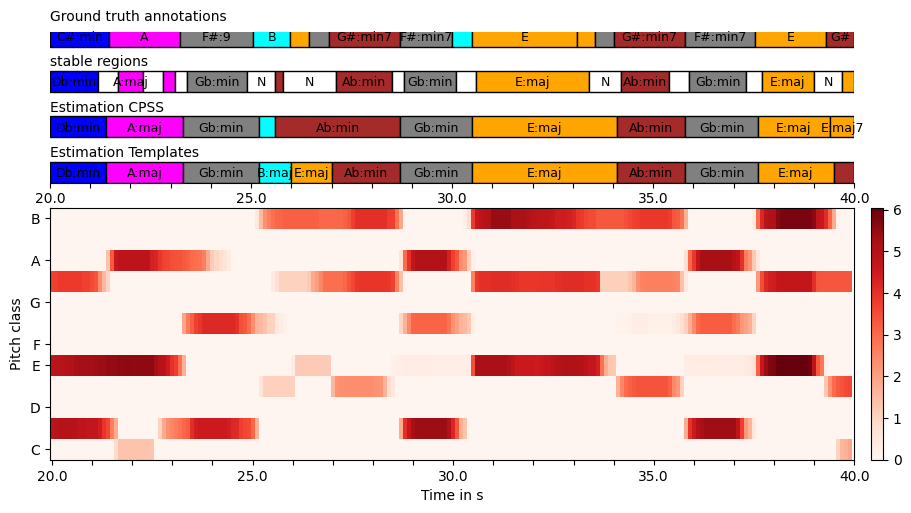

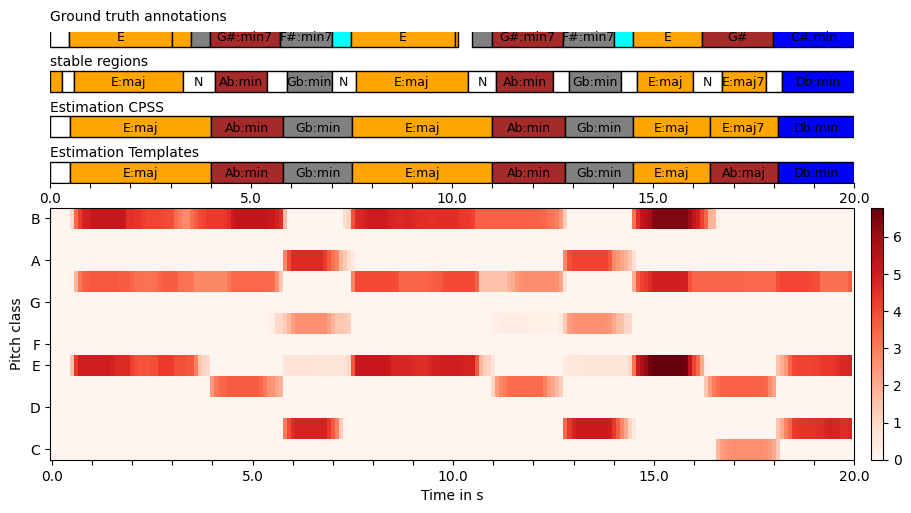

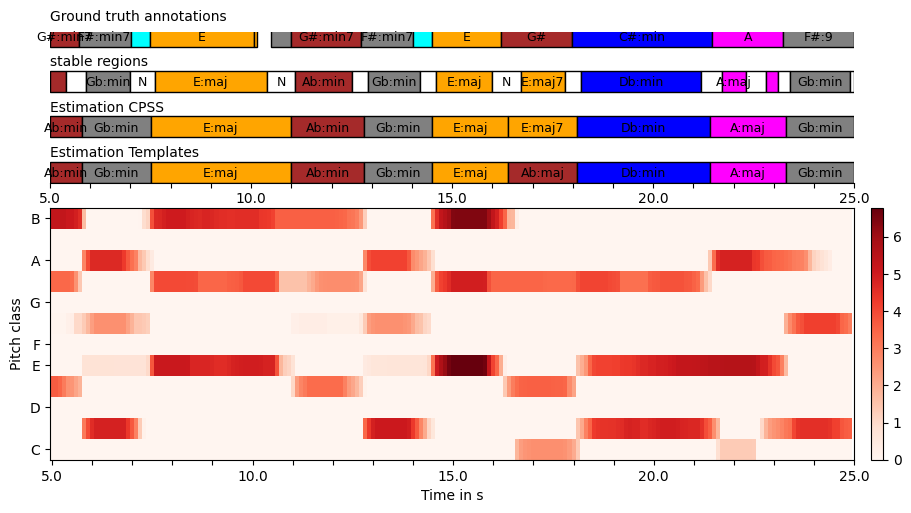

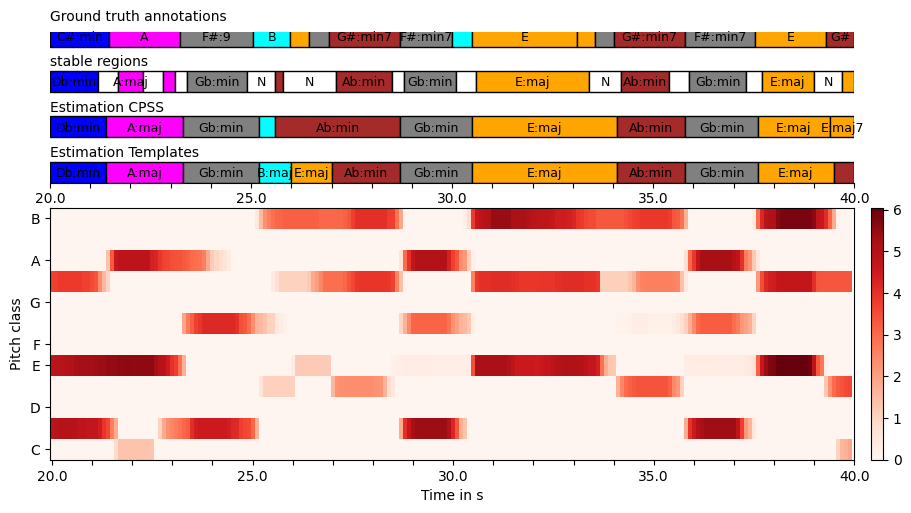

In [1]:
import visualization
import matplotlib.pyplot as plt
plt.ioff()
visualization.visualizationApp("results/");

## Evaluation of transcription 
Comparison of Stable regions transcribed with CPSS and with Template based approach

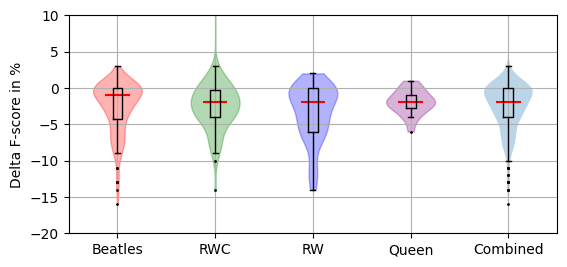

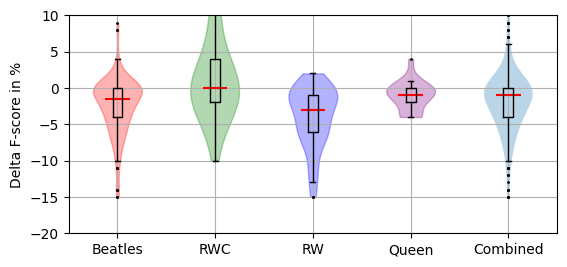

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from dataloader import OUTLIERS
# data available for:
# stable_cpss , stable_templates, est_cpss , est_templates

#experiment = "cpss_experiment.hdf5"
experiment = "deepchroma_pitchspace.hdf5"

def getFscoreResults(model="stable_cpss",alphabet="majmin"):
    results = {}
    results["combined"] = []
    with h5py.File(f"results/{experiment}","r") as file:
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in OUTLIERS:
                    f_scores.append(subgrp.attrs.get(f"{model}_{alphabet}_f"))
            results[dset] = f_scores
            results["combined"] += f_scores
    return results

def plotDeltas(delta):
    fig, ax1 = plt.subplots(figsize=(5.5, 2.5))
    parts = ax1.violinplot(delta,showmeans=False, showmedians=True,
            showextrema=False)
    bplot = ax1.boxplot(delta,
                    showfliers=True,medianprops=dict(linestyle=None,linewidth=0),
                    flierprops=dict(markerfacecolor='k', marker='o',markersize=1),
                    widths=0.1)
    parts["cmedians"].set_color("red")
    for x,color in zip(parts["bodies"],['r','g','b','purple']):
            x.set_color(color)
    xlabels = ["Beatles","RWC","RW","Queen","Combined"]
    ax1.set_yticks(np.arange(-20,25,5))
    ax1.set_ylim(-20,10)
    ax1.set_ylabel("Delta F-score in %")
    ax1.set_xticks(np.arange(1, len(xlabels) + 1), labels=xlabels)
    ax1.set_xlim(0.5, len(xlabels) + 0.5);
    ax1.grid("on")
    fig.tight_layout(pad=0.1)
    return fig,ax1

# STABLE REGIONS
stable_cpss_majmin = getFscoreResults("stable_cpss","majmin")
stable_cpss_sevenths = getFscoreResults("stable_cpss","sevenths")
stable_templates_majmin =  getFscoreResults("stable_templates","majmin")
stable_templates_sevenths =  getFscoreResults("stable_templates","sevenths")

deltas_majmin = []
deltas_sevenths = []
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    deltas_majmin.append([100*(x-y) for x,y in zip(stable_cpss_majmin[dset],stable_templates_majmin[dset])])
    deltas_sevenths.append([100*(x-y) for x,y in zip(stable_cpss_sevenths[dset],stable_templates_sevenths[dset])])

plotDeltas(deltas_majmin)
plotDeltas(deltas_sevenths);

Comparison of Template based approach with the hybrid model

(-30.0, 30.0)

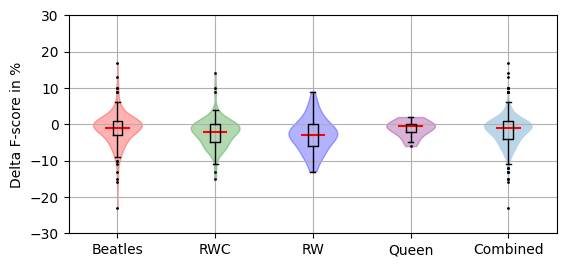

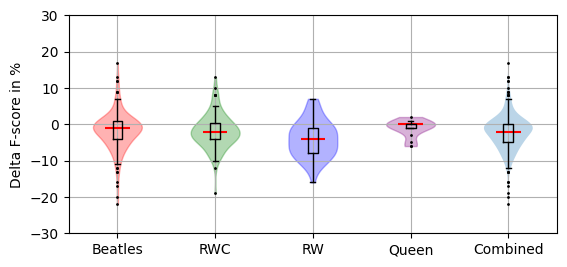

In [12]:
# STABLE REGIONS
stable_cpss_majmin = getFscoreResults("est_cpss","majmin")
stable_cpss_sevenths = getFscoreResults("est_cpss","sevenths")
stable_templates_majmin =  getFscoreResults("est_templates","majmin")
stable_templates_sevenths =  getFscoreResults("est_templates","sevenths")

deltas_majmin = []
deltas_sevenths = []
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    deltas_majmin.append([100*(x-y) for x,y in zip(stable_cpss_majmin[dset],stable_templates_majmin[dset])])
    deltas_sevenths.append([100*(x-y) for x,y in zip(stable_cpss_sevenths[dset],stable_templates_sevenths[dset])])

fig,ax = plotDeltas(deltas_majmin)
ax.set_yticks(np.arange(-30,40,10))
ax.set_ylim(-30,30);
fig,ax = plotDeltas(deltas_sevenths);
ax.set_yticks(np.arange(-30,40,10))
ax.set_ylim(-30,30);